In [1]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=1, max_count=1000000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [1290]:
marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
marker_list['gene'] = marker_list['gene'].str.upper()
#marker_list = marker_list[marker_list['rank'] < 250] 


In [1277]:
df_optimal_marker = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/optimal_number_markers.csv')



In [63]:
df_optimal_marker[df_optimal_marker['hierarchy_level'] == 'class']

Empty DataFrame
Columns: [hierarchy_level, marker_set, n_genes, f1]
Index: []

In [865]:
df_optimal_marker = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/optimal_number_markers.csv')


df_optimal_marker['n_genes'].diff()

df_optimal_marker['f1'].diff() / 

df_optimal_marker.diff() / df_optimal_marker.index.to_series().diff().dt.total_seconds()

df_optimal_marker[df_optimal_marker['hierarchy_level'] == 'class']

SyntaxError: invalid syntax (<ipython-input-865-39f6cfeed71d>, line 6)

In [64]:
marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_cluster_markers.csv')
marker_list['gene'] = marker_list['gene'].str.upper()
#marker_list = marker_list[marker_list['rank'] < 250] 


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [65]:
df_optimal_marker = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/optimal_number_markers.csv')
df_optimal_marker = df_optimal_marker[df_optimal_marker['n_genes'] >= 10]
df_optimal_marker = df_optimal_marker[df_optimal_marker['f1'] <= 0.8]
#df_optimal_marker = df_optimal_marker[df_optimal_marker['f1'] >= 0.8]
df_optimal_marker = df_optimal_marker.loc[df_optimal_marker.groupby('marker_set')['f1'].idxmax()]
#df_optimal_marker = df_optimal_marker.loc[df_optimal_marker.groupby('marker_set')['f1'].idxmin()]


In [66]:
marker_list_optimal_marker = []
for marker, n_genes in zip(df_optimal_marker['marker_set'].tolist(), df_optimal_marker['n_genes'].tolist()):
    #print (n_genes)
    
    marker_list_optimal_marker.append(marker_list[(marker_list['cell_type'] == marker) & (marker_list['rank'] <= n_genes)])
    

In [67]:
marker_list = pd.concat(marker_list_optimal_marker)

In [10]:
marker_list

group  cell_type  rank           gene  recurrence     auroc  \
0      L2/3 IT  L2/3 IT_1     1  6530403H02RIK           5  0.842734   
1      L2/3 IT  L2/3 IT_1     2        ADAMTS2           5  0.752062   
2      L2/3 IT  L2/3 IT_1     3        COL23A1           5  0.702306   
3      L2/3 IT  L2/3 IT_1     4            MET           5  0.702247   
4      L2/3 IT  L2/3 IT_1     5            UST           5  0.696202   
...        ...        ...   ...            ...         ...       ...   
53495     Sncg   Vip Sncg   496           FAT4           0  0.542318   
53496     Sncg   Vip Sncg   497         KIF26B           0  0.542200   
53497     Sncg   Vip Sncg   498          UCHL4           0  0.542014   
53498     Sncg   Vip Sncg   499           SYT5           0  0.541895   
53499     Sncg   Vip Sncg   500         RAB27B           0  0.541747   

       fold_change  fold_change_detection  expression  precision    recall  \
0         5.410202               2.606655  255.840030   0.095304  0.830882   
1         7.557666               4.621909   99.357999   0.152135  0.582932   
2        12.460411               7.980352   61.676311   0.219897  0.446298   
3         9.147210               6.442665   53.928589   0.201546  0.445979   
4         6.217147               3.645296   59.489654   0.121974  0.479271   
...            ...                    ...         ...        ...       ...   
53495     3.819274               2.631081   13.041018   0.409894  0.133476   
53496     1.334584               1.135989   47.706334   0.232890  0.419233   
53497     1.518957               1.007401    9.047279   0.219944  0.302305   
53498     1.417339               0.999033   76.087906   0.212484  0.496707   
53499     1.246782               1.019633  126.686872   0.216386  0.615720   

       population_size  n_datasets   scSS   snSS  scCv2  snCv2  snCv3M  scCv3  \
0           492.833333           6    NaN  False   True   True    True   True   
1           492.833333           6    NaN  False   True   True    True   True   
2           492.833333           6    NaN  False   True   True    True   True   
3           492.833333           6    NaN  False   True   True    True   True   
4           492.833333           6    NaN  False   True   True    True   True   
...                ...         ...    ...    ...    ...    ...     ...    ...   
53495        78.000000           7  False  False  False  False   False  False   
53496        78.000000           7  False  False  False  False   False  False   
53497        78.000000           7  False  False  False  False   False  False   
53498        78.000000           7  False  False  False  False   False  False   
53499        78.000000           7  False  False  False  False   False  False   

      snCv3Z  
0       True  
1       True  
2       True  
3       True  
4       True  
...      ...  
53495  False  
53496  False  
53497  False  
53498  False  
53499  False  

[21640 rows x 20 columns]

In [68]:
df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
marker_list = marker_list.merge(df_ensg_name, right_on='gene', left_on='gene') 


In [69]:
marker_table = marker_list.pivot(index='gene_id', columns='cell_type', values='rank')

In [70]:
marker_table.fillna(0, inplace=True)

In [71]:
marker_table[marker_table != 0] = 1

(6387, 6387)
(6387, 80)
0.9595095506497573
0.0


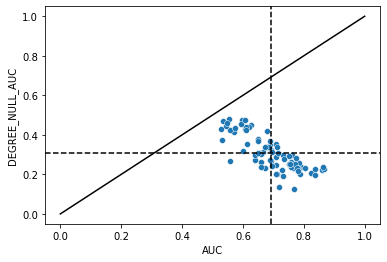

In [75]:
df_2d_jac, go_chrom  = run_egad(marker_table, df_spr_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

(6387, 6387)
(6387, 80)
0.9595095506497573
0.0


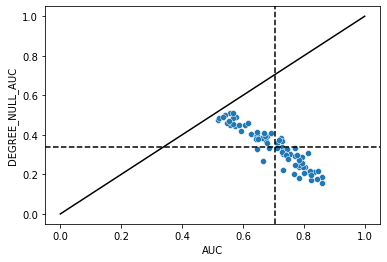

In [63]:
df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr_list[7])
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

(6387, 6387)
(6387, 80)
0.9595095506497573
0.0


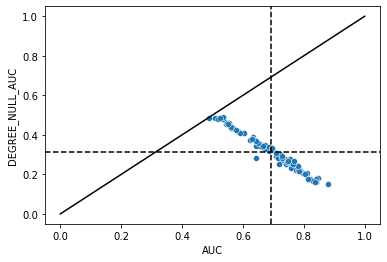

In [42]:
df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr_list[1])
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [37]:
df_2d_jac['AUC'].median()

0.7259797585529112

In [43]:
df_2d_jac['AUC'].median()

0.7131575855725043

In [51]:
df_2d_jac['AUC'].median()

0.7350516750897755

In [53]:
df_2d_jac['AUC'].median()

0.7348074077075757

In [55]:
df_2d_jac['AUC'].median()

0.7378340915461538

In [60]:
df_2d_jac['AUC'].median()

0.7404384844022516

In [64]:
df_2d_jac['AUC'].median()

0.7285538217933243

In [1070]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value
cell_type                                                           
L2/3 IT     0.776499      1907.539908         0.266037  6.117289e-02
L5 ET       0.708926      2078.763478         0.405904  4.068222e-02
L5 IT       0.904952      1443.010231         0.122314  3.091574e-03
L5/6 NP     0.535520      2095.223203         0.477477  1.902989e-04
L6 CT       0.530231      2122.446097         0.503568  1.148105e-03
L6 IT       0.720077      1787.250933         0.340945  1.911592e-03
L6 IT Car3  0.528872      2101.590189         0.493441  1.750325e-03
L6b         0.526045      2120.717126         0.504588  4.683895e-03
Sncg        0.593239      1998.664713         0.402004  3.887993e-03
Vip         0.581293      2037.939976         0.444929  2.470167e-16

In [1341]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
cell_type                                                          
GABAergic      0.756725        17.896457         0.430622  0.003177
Glutamatergic  0.687831        18.717524         0.582011  0.052311
Non-Neuronal   0.820833        18.033159         0.495000  0.000998

In [808]:
df_2d_jac['AUC'].mean()

0.8417328042328043

(4618, 4618)
(4618, 80)
0.9378545907319186
0.0


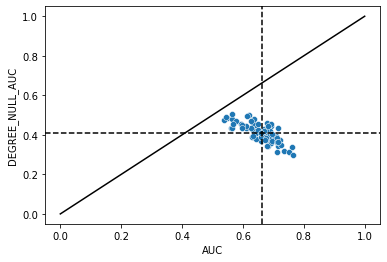

In [1190]:
df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [1191]:
df_2d_jac['AUC'].mean()

0.661282315479487

In [538]:
df_optimal_marker

hierarchy_level      marker_set  n_genes        f1
8              class       GABAergic      500  0.997599
20             class   Glutamatergic      200  0.999537
1177        subclass         L2/3 IT      100  0.908418
44     joint_cluster       L2/3 IT_1       50  0.517432
59     joint_cluster       L2/3 IT_2      200  0.548169
...              ...             ...      ...       ...
1110   joint_cluster    Vip Mybpc1_3       20  0.594133
1123   joint_cluster  Vip Serpinf1_1       20  0.414391
1138   joint_cluster  Vip Serpinf1_2      100  0.870805
1150   joint_cluster  Vip Serpinf1_3       50  0.566260
1165   joint_cluster        Vip Sncg      200  0.837217

[101 rows x 4 columns]

In [1314]:
df_2d_jac = df_2d_jac.merge(df_optimal_marker, left_on=df_2d_jac.index, right_on='marker_set')

In [1315]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value hierarchy_level  \
0  0.494175      1193.630474         0.507786  0.127781           class   
1  0.504788      1178.113422         0.491181  0.256743           class   
2  0.603737      1270.614887         0.554007  0.112343           class   

      marker_set  n_genes        f1  
0      GABAergic    10000  0.915857  
1  Glutamatergic    10000  0.978755  
2   Non-Neuronal       10  0.946366

<AxesSubplot:xlabel='f1', ylabel='AUC'>

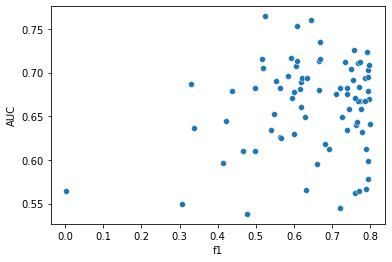

In [1193]:
sns.scatterplot(y=df_2d_jac['AUC'], x=df_2d_jac['f1'])

<AxesSubplot:xlabel='n_genes', ylabel='AUC'>

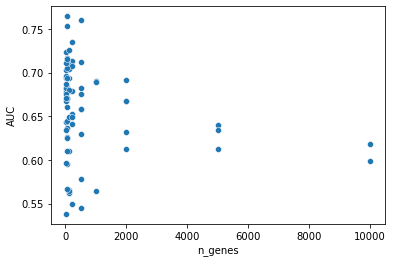

In [1194]:
sns.scatterplot(y=df_2d_jac['AUC'], x=df_2d_jac['n_genes'])

In [1180]:
df_2d_jac['n_genes']

0       50
1      200
2     5000
3     5000
4      200
      ... 
75      20
76      20
77     500
78      50
79     500
Name: n_genes, Length: 80, dtype: int64

<AxesSubplot:xlabel='f1', ylabel='AUC'>

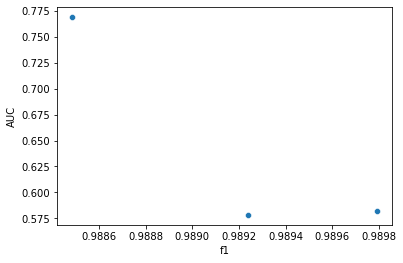

In [784]:
sns.scatterplot(y=df_2d_jac['AUC'], x=df_2d_jac['f1'])

<AxesSubplot:xlabel='f1', ylabel='AUC'>

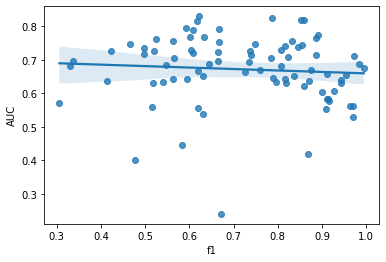

In [524]:
sns.regplot(y=df_2d_jac['AUC'], x=df_2d_jac['f1'])

In [468]:
df_2d_jac['AUC'].mean()

0.671356340110002

In [ ]:
df_optimal_marker

In [370]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
cell_type                                                          
GABAergic      0.756725        17.896457         0.430622  0.003177
Glutamatergic  0.687831        18.717524         0.582011  0.052311
Non-Neuronal   0.820833        18.033159         0.495000  0.000998

In [311]:
df_optimal_marker = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/optimal_number_markers.csv')


df_optimal_marker.loc[df_optimal_marker.groupby('marker_set')['f1'].idxmax()]

In [213]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value
cell_type                                                               
L2/3 IT_1       0.733561      3506.493796         0.412596  1.739606e-55
L2/3 IT_2       0.637985      3629.579985         0.439401  2.336410e-20
L2/3 IT_3       0.535113      3733.917255         0.449737  5.855890e-05
L4/5 IT_1       0.641127      3507.638301         0.372313  1.321543e-21
L4/5 IT_2       0.645324      3592.453424         0.420676  1.643804e-22
...                  ...              ...              ...           ...
Vip Mybpc1_3    0.652867      3576.540368         0.406425  7.652021e-25
Vip Serpinf1_1  0.591255      3674.055112         0.427297  7.084149e-10
Vip Serpinf1_2  0.690646      3617.295280         0.413061  3.120479e-37
Vip Serpinf1_3  0.643637      3728.302092         0.450042  3.313931e-22
Vip Sncg        0.663067      3511.266429         0.397031  7.070980e-28

[86 rows x 4 columns]

In [4]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import pandas as pd

In [185]:
SRP_name='aggregates'
resolution='10kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/spr/0/all_bins/KR_KR/hic_gene_corr_intra_nanranked.h5'

jac_sim_intra = hm.hiCMatrix(exp_file_path)




all_genes = [x[3].decode() for x in jac_sim_intra.cut_intervals]
df_jac_corr_intra = pd.DataFrame(jac_sim_intra.matrix.toarray() ,  index=all_genes, columns = all_genes)


In [198]:
df_jac_corr = df_jac_corr / df_jac_corr.max().max()

55410.54265398567

In [199]:
df_jac_corr = df_jac_corr / df_jac_corr.max().max()

In [200]:
df_jac_gw = df_jac_corr_intra  + df_jac_corr

In [34]:
    species_list = ['mouse']
    if species_list == ['human']:
        color_1 = '#98DBF6'
        color_2 = '#00A5E6'
    elif species_list == ['mouse']:
        color_1 = '#F69398'
        color_2 = '#E83B43'
    else:
        color_1 = '#E9DBC4'
        color_2 = '#EC9200'        
    
    res_list = [25]
    #res_list = [10]
    #KR_type_list = ['KR_ranked_KR']
    KR_type_list = ['KR']
    #performance_type_list = ['all']
    edge_type_list = ['contact']
    #performance_type_list = ['inter_only/hic_gene_KR_inter_1_percent_per_chr.csv']
    performance_type_list = ['inter_only/hic_gene_corr_inter_excluding_intra_nanranked_1_percent_per_chr.csv']
    
    #f_name = 'hic_gene_corr_inter_1_percent_per_chr.csv'
    #f_name = 'hic_gene_KR_intra_1_percent_per_chr.csv'
    #f_name = 'hic_gene_corr_gw_1_percent_per_chr.csv'

    df_list = []
    for species in species_list: 
        df_seq_depth = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_exclude_count_inter.txt', sep='\t')
        df_seq_depth['species'] = species
        df_list.append(df_seq_depth)

In [47]:
    species_list = ['mouse']
    if species_list == ['human']:
        color_1 = '#98DBF6'
        color_2 = '#00A5E6'
    elif species_list == ['mouse']:
        color_1 = '#F69398'
        color_2 = '#E83B43'
    else:
        color_1 = '#E9DBC4'
        color_2 = '#EC9200'        
    
    res_list = [10]
    #res_list = [10]
    #KR_type_list = ['KR_ranked_KR']
    KR_type_list = ['KR']
    #performance_type_list = ['all']
    edge_type_list = ['contact']
    #performance_type_list = ['inter_only/hic_gene_KR_inter_1_percent_per_chr.csv']
    performance_type_list = ['inter_only/hic_gene_corr_inter_excluding_intra_nanranked_1_percent_per_chr.csv']
    
    #f_name = 'hic_gene_corr_inter_1_percent_per_chr.csv'
    #f_name = 'hic_gene_KR_intra_1_percent_per_chr.csv'
    #f_name = 'hic_gene_corr_gw_1_percent_per_chr.csv'

    df_list = []
    for species in species_list: 
        df_seq_depth = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_exclude_count_inter.txt', sep='\t')
        df_seq_depth['species'] = species
        df_list.append(df_seq_depth)

    #whole aggreagte
    import pandas as pd
    empty_list = []

    for species in species_list: 
    #for species in ['human']: 
      #for bin_type in ['gene_bins', 'all_bins', 'non_gene']: 
      for bin_type in ['all_bins']: 
        for resolution in res_list:
            for coef in ['jac_sim']:
            #for coef in ['pcc', 'jac_sim']:
              #for mapping in ['tss']:
              for mapping in ['max']:
                #for percentile in [90]:
                for percentile in [90]:
                    for gene_percentile in [1]:
                    #for gene_percentile in [10]:

                        for KR_type in KR_type_list:
                            for performance_type, agg_type in zip(['/spr/0/all_bins/KR_KR/inter_only/hic_gene_corr_inter_excluding_intra_nanranked_1_percent_per_chr.csv', '/spr/0/all_bins/KR_KR/inter_only/hic_gene_corr_inter_excluding_intra_nanranked_ind_1_percent_per_chr.csv'], ['spearman']):

                                file_path = f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/data_{species}/aggregates/'

                                file_name = f'{resolution}kbp_raw/{mapping}/{performance_type}'
                                
                                SRP_name = 'aggregates'
                                
                                exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}kbp_raw/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

                                jac_sim = hm.hiCMatrix(exp_file_path)




                                all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
                                #df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)
                                df_spr_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)



                                try:


                                    df2, delo = run_egad(marker_table, df_spr_corr)
                                    df2['species'] = species
                                    df2['resolution'] = resolution
                                    df2['agg_type'] = agg_type
                                    df2['proj'] = 'all'
                                    df2['edge_type'] = ''
                                    empty_list.append(df2)
                                except:
                                    continue
    df_whole_agg=pd.concat(empty_list)       
    df_whole_agg['counts_inter'] = df_seq_depth['counts_inter'].sum()
    print (df_whole_agg.groupby(['resolution', 'agg_type'])['AUC'].mean())
    
    


(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
resolution  agg_type
10          spearman    0.715911
Name: AUC, dtype: float64


In [74]:
df_spr_corr

ENSMUSG00000102693  ENSMUSG00000064842  \
ENSMUSG00000102693            0.999989            0.091126   
ENSMUSG00000064842            0.091126            1.000000   
ENSMUSG00000051951            0.042889            0.056969   
ENSMUSG00000102851            0.118388            0.152995   
ENSMUSG00000103377            0.164761            0.231801   
...                                ...                 ...   
ENSMUSG00000070263            0.116297            0.232773   
ENSMUSG00000094649            0.103342            0.175343   
ENSMUSG00000069475            0.102819            0.194855   
ENSMUSG00000059326            0.147300            0.322675   
ENSMUSG00000095993            0.108835            0.332005   

                    ENSMUSG00000051951  ENSMUSG00000102851  \
ENSMUSG00000102693            0.042889            0.118388   
ENSMUSG00000064842            0.056969            0.152995   
ENSMUSG00000051951            1.000000            0.587005   
ENSMUSG00000102851            0.587005            1.000000   
ENSMUSG00000103377            0.452241            0.322573   
...                                ...                 ...   
ENSMUSG00000070263            0.046414            0.301596   
ENSMUSG00000094649            0.048160            0.173749   
ENSMUSG00000069475            0.047927            0.211905   
ENSMUSG00000059326            0.060510            0.369321   
ENSMUSG00000095993            0.055908            0.262783   

                    ENSMUSG00000103377  ENSMUSG00000104017  \
ENSMUSG00000102693            0.164761            0.112540   
ENSMUSG00000064842            0.231801            0.232695   
ENSMUSG00000051951            0.452241            0.724443   
ENSMUSG00000102851            0.322573            0.221674   
ENSMUSG00000103377            1.000000            0.207181   
...                                ...                 ...   
ENSMUSG00000070263            0.325391            0.249391   
ENSMUSG00000094649            0.206390            0.120195   
ENSMUSG00000069475            0.213624            0.167080   
ENSMUSG00000059326            0.417791            0.351578   
ENSMUSG00000095993            0.345242            0.326246   

                    ENSMUSG00000103025  ENSMUSG00000089699  \
ENSMUSG00000102693            0.159532            0.098523   
ENSMUSG00000064842            0.217658            0.207653   
ENSMUSG00000051951            0.424368            0.999960   
ENSMUSG00000102851            0.249150            0.277009   
ENSMUSG00000103377            0.301403            0.345862   
...                                ...                 ...   
ENSMUSG00000070263            0.298799            0.360378   
ENSMUSG00000094649            0.191816            0.276124   
ENSMUSG00000069475            0.309829            0.338047   
ENSMUSG00000059326            0.386470            0.548589   
ENSMUSG00000095993            0.398001            0.498257   

                    ENSMUSG00000103201  ENSMUSG00000103147  ...  \
ENSMUSG00000102693            0.073155            0.094609  ...   
ENSMUSG00000064842            0.208447            0.280814  ...   
ENSMUSG00000051951            0.834338            0.566007  ...   
ENSMUSG00000102851            0.141470            0.185272  ...   
ENSMUSG00000103377            0.204697            0.306185  ...   
...                                ...                 ...  ...   
ENSMUSG00000070263            0.230062            0.316854  ...   
ENSMUSG00000094649            0.124247            0.250131  ...   
ENSMUSG00000069475            0.155388            0.204897  ...   
ENSMUSG00000059326            0.211930            0.317868  ...   
ENSMUSG00000095993            0.159163            0.296880  ...   

                    ENSMUSG00000024997  ENSMUSG00000003228  \
ENSMUSG00000102693            0.113291            0.045060   
ENSMUSG00000064842            0.363727            0.083031   
ENSMUSG00000051951            0.078999           

In [48]:
    counter = 0
    performance_type_list = ['inter_only/hic_gene_corr_inter_excluding_intra_nanranked_1_percent_per_chr.csv']
    for species in species_list: 
        contacts_path = f'/grid/gillis/data/nfox/hi_c_data_processing/data_{species}/stats/'
        df_con = pd.read_csv(f'{contacts_path}/project_network_counts.txt', sep=' ', names=['id', 'count'])

        import pandas as pd
        empty_list = []

        for proj in df_con['id'].tolist():
              counter = counter + 1
              

              #for species in ['drosophila', 'drosophila', 'drosophila']: 

              #for bin_type in ['gene_bins', 'all_bins', 'non_gene']: 
              for bin_type in ['all_bins']: 
                for resolution in res_list:
                    for coef in ['jac_sim']:
                    #for coef in ['pcc', 'jac_sim']:
                      #for mapping in ['tss']:
                      for mapping in ['max/spr/0/all_bins/KR_KR']:
                        #print (proj)
                        for percentile in ['90']:
                            for KR_type in KR_type_list:
                                for performance_type in performance_type_list:
                                #for performance_type in ['intra_only', 'inter_only', 'all']:
                                    file_path = f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/data_{species}/{proj}/'
                                    file_name = f'{resolution}kbp_raw/{mapping}/{performance_type}'
                                    
                                    SRP_name = proj
                                
                                    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}kbp_raw/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

                                    jac_sim = hm.hiCMatrix(exp_file_path)




                                    all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
                                    #df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)
                                    df_spr_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)




                                    #file_name = f'{resolution}kbp_raw/{mapping}/{coef}/{percentile}/{bin_type}/{KR_type}/{performance_type}/{f_name}'

                                    try:

                                        df2, delo = run_egad(marker_table, df_spr_corr)
                                        print ('AUC')
                                        print (df2['AUC'].mean())
                                        df2['species'] = species
                                        df2['resolution'] = resolution
                                        df2['proj'] = proj
                                        df2['agg_type'] = 'proj_agg'
                                        #print (proj)
                                        
                                        df_seq_depth_subset = df_seq_depth[df_seq_depth['proj_id'].isin([proj])]
                                        df2['counts_inter'] = df_seq_depth_subset['counts_inter'].sum()


                                    except:
                                        #print (f'{file_path}/{file_name}')
                                        print (counter, proj, resolution)
                                        
                                        continue


                                    empty_list.append(df2)
    df_ind=pd.concat(empty_list)

    df = pd.concat([df_whole_agg, df_ind])

    dt = df.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()

    for species in species_list: 
        df_seq_depth = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_project_network_details.tsv', sep='\t')
        df_seq_depth['species'] = species
        df_seq_depth['project'] = [x.strip() for x in df_seq_depth['project']]
        df_seq_depth['experiment type'] = [x.strip() for x in df_seq_depth['experiment type']]
        #dk['experiment type'] = [x if x=='Hi-C' else 'o' for x in dk['experiment type']]

    import numpy as np
    dt['log_contacts'] = [np.log10(x) for x in dt['counts_inter']]

    dt = dt.merge(df_seq_depth, left_on='proj', right_on='project')
    dk = pd.concat([dt, df_whole_agg.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()])
    dk['log_contacts'] = [np.log10(x) for x in dk['counts_inter']]

    dk['experiment type'] = [x if x=='Hi-C' else 'o' for x in dk['experiment type']]
    
    #dk = dk[dk['auc'] > 0.5]
    #dk = dk[dk['agg_type']=='proj_agg']
    #print (dk)
    
    
    



(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.6103467235135465
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.5599861684468066
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7066034917103047
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7231573228352367
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.718326347874062
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.3551680145730444
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.6798085798792235
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.3944035784095749
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.6864886699479629
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.4371360221513571
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.6687111145764347
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.3778668743845887
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.6675157683103421
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7216254922242987
(6387, 6387)
(6387, 8

<ipython-input-48-a7008f8e7488>:76: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dt = df.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()
<ipython-input-48-a7008f8e7488>:89: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dk = pd.concat([dt, df_whole_agg.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()])


In [42]:
    counter = 0
    performance_type_list = ['inter_only/hic_gene_corr_inter_excluding_intra_nanranked_1_percent_per_chr.csv']
    for species in species_list: 
        contacts_path = f'/grid/gillis/data/nfox/hi_c_data_processing/data_{species}/stats/'
        df_con = pd.read_csv(f'{contacts_path}/project_network_counts.txt', sep=' ', names=['id', 'count'])

        import pandas as pd
        empty_list = []

        for proj in df_con['id'].tolist():
              counter = counter + 1
              

              #for species in ['drosophila', 'drosophila', 'drosophila']: 

              #for bin_type in ['gene_bins', 'all_bins', 'non_gene']: 
              for bin_type in ['all_bins']: 
                for resolution in res_list:
                    for coef in ['jac_sim']:
                    #for coef in ['pcc', 'jac_sim']:
                      #for mapping in ['tss']:
                      for mapping in ['max/spr/0/all_bins/KR_KR']:
                        #print (proj)
                        for percentile in ['90']:
                            for KR_type in KR_type_list:
                                for performance_type in performance_type_list:
                                #for performance_type in ['intra_only', 'inter_only', 'all']:
                                    file_path = f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/data_{species}/{proj}/'
                                    file_name = f'{resolution}kbp_raw/{mapping}/{performance_type}'
                                    
                                    SRP_name = proj
                                
                                    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}kbp_raw/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

                                    jac_sim = hm.hiCMatrix(exp_file_path)




                                    all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
                                    #df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)
                                    df_spr_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)




                                    #file_name = f'{resolution}kbp_raw/{mapping}/{coef}/{percentile}/{bin_type}/{KR_type}/{performance_type}/{f_name}'

                                    try:

                                        df2, delo = run_egad(marker_table, df_spr_corr)
                                        print ('AUC')
                                        print (df2['AUC'].mean())
                                        df2['species'] = species
                                        df2['resolution'] = resolution
                                        df2['proj'] = proj
                                        df2['agg_type'] = 'proj_agg'
                                        #print (proj)
                                        
                                        df_seq_depth_subset = df_seq_depth[df_seq_depth['proj_id'].isin([proj])]
                                        df2['counts_inter'] = df_seq_depth_subset['counts_inter'].sum()


                                    except:
                                        #print (f'{file_path}/{file_name}')
                                        print (counter, proj, resolution)
                                        
                                        continue


                                    empty_list.append(df2)
    df_ind=pd.concat(empty_list)

    df = pd.concat([df_whole_agg, df_ind])

    dt = df.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()

    for species in species_list: 
        df_seq_depth = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_project_network_details.tsv', sep='\t')
        df_seq_depth['species'] = species
        df_seq_depth['project'] = [x.strip() for x in df_seq_depth['project']]
        df_seq_depth['experiment type'] = [x.strip() for x in df_seq_depth['experiment type']]
        #dk['experiment type'] = [x if x=='Hi-C' else 'o' for x in dk['experiment type']]

    import numpy as np
    dt['log_contacts'] = [np.log10(x) for x in dt['counts_inter']]

    dt = dt.merge(df_seq_depth, left_on='proj', right_on='project')
    dk = pd.concat([dt, df_whole_agg.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()])
    dk['log_contacts'] = [np.log10(x) for x in dk['counts_inter']]

    dk['experiment type'] = [x if x=='Hi-C' else 'o' for x in dk['experiment type']]
    
    #dk = dk[dk['auc'] > 0.5]
    #dk = dk[dk['agg_type']=='proj_agg']
    #print (dk)
    
    
    



(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.6592254534397619
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.6352146472819639
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7051118288110804
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7160428727542091
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7128078168763238
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.3587179751213616
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7013168436171205
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.39434961738068847
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7031020804606621
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.4286326171443055
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.6889362287595999
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.36623767019056397
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.6816405075249692
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7207182638605036
(6387, 6387)
(6387

<ipython-input-42-a7008f8e7488>:76: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dt = df.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()
<ipython-input-42-a7008f8e7488>:89: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dk = pd.concat([dt, df_whole_agg.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()])


In [29]:
    counter = 0
    performance_type_list = ['inter_only/hic_gene_corr_inter_excluding_intra_nanranked_1_percent_per_chr.csv']
    for species in species_list: 
        contacts_path = f'/grid/gillis/data/nfox/hi_c_data_processing/data_{species}/stats/'
        df_con = pd.read_csv(f'{contacts_path}/project_network_counts.txt', sep=' ', names=['id', 'count'])

        import pandas as pd
        empty_list = []

        for proj in df_con['id'].tolist():
              counter = counter + 1
              

              #for species in ['drosophila', 'drosophila', 'drosophila']: 

              #for bin_type in ['gene_bins', 'all_bins', 'non_gene']: 
              for bin_type in ['all_bins']: 
                for resolution in res_list:
                    for coef in ['jac_sim']:
                    #for coef in ['pcc', 'jac_sim']:
                      #for mapping in ['tss']:
                      for mapping in ['max/spr/0/all_bins/KR_KR']:
                        #print (proj)
                        for percentile in ['90']:
                            for KR_type in KR_type_list:
                                for performance_type in performance_type_list:
                                #for performance_type in ['intra_only', 'inter_only', 'all']:
                                    file_path = f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/data_{species}/{proj}/'
                                    file_name = f'{resolution}kbp_raw/{mapping}/{performance_type}'
                                    
                                    SRP_name = proj
                                
                                    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}kbp_raw/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

                                    jac_sim = hm.hiCMatrix(exp_file_path)




                                    all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
                                    #df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)
                                    df_spr_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)




                                    #file_name = f'{resolution}kbp_raw/{mapping}/{coef}/{percentile}/{bin_type}/{KR_type}/{performance_type}/{f_name}'

                                    try:

                                        df2, delo = run_egad(marker_table, df_spr_corr)
                                        print ('AUC')
                                        print (df2['AUC'].mean())
                                        df2['species'] = species
                                        df2['resolution'] = resolution
                                        df2['proj'] = proj
                                        df2['agg_type'] = 'proj_agg'
                                        #print (proj)
                                        
                                        df_seq_depth_subset = df_seq_depth[df_seq_depth['proj_id'].isin([proj])]
                                        df2['counts_inter'] = df_seq_depth_subset['counts_inter'].sum()


                                    except:
                                        #print (f'{file_path}/{file_name}')
                                        print (counter, proj, resolution)
                                        
                                        continue


                                    empty_list.append(df2)
    df_ind=pd.concat(empty_list)

    df = pd.concat([df_whole_agg, df_ind])

    dt = df.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()

    for species in species_list: 
        df_seq_depth = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_project_network_details.tsv', sep='\t')
        df_seq_depth['species'] = species
        df_seq_depth['project'] = [x.strip() for x in df_seq_depth['project']]
        df_seq_depth['experiment type'] = [x.strip() for x in df_seq_depth['experiment type']]
        #dk['experiment type'] = [x if x=='Hi-C' else 'o' for x in dk['experiment type']]

    import numpy as np
    dt['log_contacts'] = [np.log10(x) for x in dt['counts_inter']]

    dt = dt.merge(df_seq_depth, left_on='proj', right_on='project')
    dk = pd.concat([dt, df_whole_agg.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()])
    dk['log_contacts'] = [np.log10(x) for x in dk['counts_inter']]

    dk['experiment type'] = [x if x=='Hi-C' else 'o' for x in dk['experiment type']]
    
    #dk = dk[dk['auc'] > 0.5]
    #dk = dk[dk['agg_type']=='proj_agg']
    #print (dk)
    
    
    



(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.6592254534397619
1 SRP249897 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.6352146472819639
2 SRP292639 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7051118288110804
3 SRP217487 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7160428727542091
4 SRP075985 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7128078168763238
5 SRP105082 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.3587179751213616
6 SRP110616 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7013168436171205
7 SRP118601 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.39434961738068847
8 SRP200567 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7031020804606621
9 SRP223513 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.4286326171443055
10 SRP218950 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.6889362287595999
11 SRP226118 25
(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.366237670

ValueError: No objects to concatenate

In [37]:
                                        df2, delo = run_egad(marker_table, df_spr_corr)
                                        print ('AUC')
                                        print (df2['AUC'].mean())
                                        df2['species'] = species
                                        df2['resolution'] = resolution
                                        df2['proj'] = proj
                                        df2['agg_type'] = 'proj_agg'
                                        #print (proj)
                                        
                                        df_seq_depth_subset = df_seq_depth[df_seq_depth['proj_id'].isin([proj])]
                                        df2['counts_inter'] = df_seq_depth_subset['counts_inter'].sum()

(6387, 6387)
(6387, 80)
0.9595095506497573
0.0
AUC
0.7119203363432131


In [35]:
df_seq_depth

proj_id      srx_id       run_id  counts_inter species
0     SRP249897  SRX7755137  SRR11118383        128088   mouse
1     SRP249897  SRX7743243  SRR11105815         91010   mouse
2     SRP249897  SRX7757436  SRR11120501           240   mouse
3     SRP249897  SRX7756045  SRR11118813         91808   mouse
4     SRP249897  SRX7743501  SRR11105557         93382   mouse
...         ...         ...          ...           ...     ...
6674  SRP261290  SRX8350007  SRR11798548      71210268   mouse
6675  SRP261290  SRX8350006  SRR11798546      89116604   mouse
6676  SRP261290  SRX8350006  SRR11798547      89253714   mouse
6677  SRP261290  SRX8350009  SRR11798552      81019912   mouse
6678  SRP261290  SRX8350009  SRR11798553      82090246   mouse

[6679 rows x 5 columns]

In [30]:
empty_list

[]

In [23]:
import seaborn as sns
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
dk[dk['resolution']==10]

proj  resolution  agg_type       AUC  counts_inter  log_contacts  \
0   ERP114475          10  proj_agg  0.658694     329576950      8.517957   
1   SRP075985          10  proj_agg  0.723157    4463102620      9.649637   
2   SRP096571          10  proj_agg  0.663594     212179138      8.326703   
3   SRP100871          10  proj_agg  0.684704     526403612      8.721319   
4   SRP101928          10  proj_agg  0.707454    6160271418      9.789600   
5   SRP105082          10  proj_agg  0.718326    3365835632      9.527093   
6   SRP107774          10  proj_agg  0.721625    1652774044      9.218213   
7   SRP110616          10  proj_agg  0.355168     104226676      8.017979   
8   SRP118601          10  proj_agg  0.679809    1810904034      9.257895   
9   SRP119332          10  proj_agg  0.689480     688241168      8.837741   
10  SRP131117          10  proj_agg  0.673338     851552372      8.930211   
11  SRP144391          10  proj_agg  0.559884     193612804      8.286934   
12  SRP156597          10  proj_agg  0.667516     455536646      8.658523   
13  SRP165933          10  proj_agg  0.702249    1952549990      9.290602   
14  SRP179647          10  proj_agg  0.703894     535116088      8.728448   
15  SRP192917          10  proj_agg  0.688494     492438182      8.692352   
16  SRP194410          10  proj_agg  0.377867      17278402      7.237504   
17  SRP200567          10  proj_agg  0.394404      16292950      7.212000   
18  SRP217487          10  proj_agg  0.706603   51833900034     10.714614   
19  SRP218950          10  proj_agg  0.437136      10079064      7.003420   
20  SRP223513          10  proj_agg  0.686489     756594390      8.878863   
21  SRP226118          10  proj_agg  0.668711    1195070040      9.077393   
22  SRP227097          10  proj_agg  0.681003     442224358      8.645643   
23  SRP229756          10  proj_agg  0.678409     879256390      8.944116   
24  SRP247488          10  proj_agg  0.675420     771789272      8.887499   
25  SRP249897          10  proj_agg  0.610347     262699646      8.419459   
26  SRP250878          10  proj_agg  0.669563     853812632      8.931363   
27  SRP252213          10  proj_agg  0.682943    1000319750      9.000139   
28  SRP255620          10  proj_agg  0.674060     532658360      8.726449   
29  SRP261290          10  proj_agg  0.690810    1827183488      9.261782   
30  SRP268173          10  proj_agg  0.697328     581117420      8.764264   
31  SRP270993          10  proj_agg  0.704581     561311230      8.749204   
32  SRP292639          10  proj_agg  0.559986      75510394      7.878007   
0         all          10  spearman  0.715911   85411419194     10.931516   

      project    runs experiment type                      experiment type2  \
0   ERP114475    24.0            Hi-C                                  Hi-C   
1   SRP075985   573.0            Hi-C                                  Hi-C   
2   SRP096571    48.0            Hi-C                                  Hi-C   
3   SRP100871    30.0               o        Hi-C and promoter capture Hi-C   
4   SRP101928    56.0            Hi-C                               in Hi-C   
5   SRP105082   361.0               o   ChIA-PET, insitu Hi-C, 4C, localHiC   
6   SRP107774    60.0            Hi-C                               in Hi-C   
7   SRP110616   211.0               o         single-nucleus Hi-C (snHi-C)    
8   SRP118601   200.0            Hi-C                               in Hi-C   
9   SRP119332    37.0               o  Allele-specific and traditional Hi-C   
10  SRP131117    21.0               o                 low-input Hi-C method   
11  SRP144391    52.0            Hi-C                                  Hi-C   
12  SRP156597    63.0               o      low-input Hi-C (sisHi-C), snHi-C   
13  SRP165933    22.0            Hi-C                                  Hi-C   
14  SRP179647    48.0            Hi-C                                  Hi-C   
15  SRP192917    35.0            Hi-C            

[]

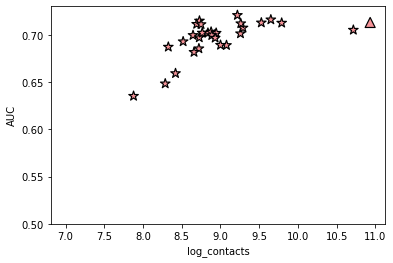

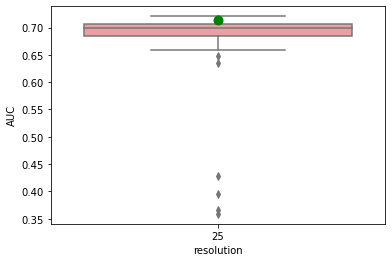

In [46]:
    
    import matplotlib.pyplot as plt
    sc_bar = sns.scatterplot(data=dk[dk['resolution']==25], x='log_contacts', y='AUC', style='agg_type', color=color_1,edgecolor="black", s=100, linewidth=1.2, markers =  {"proj_agg": "*", "pearson": "o", "spearman": "^"})
    sc_bar.legend().remove()
    #sc_bar = sns.scatterplot(data=dk[dk['resolution']==100], x='log_contacts', y='auc')
    #dk['log_contacts'] = dk['log_contacts'].round(0)
    #sc_bar = sns.lineplot(data=dk[dk['resolution']==10], x='log_contacts', y='auc')
    
    #sc_bar = sns.regplot(data=dk[dk['resolution']==10], x='log_contacts', y='auc')
    sc_bar.set(ylim=(0.5, 0.73))
    plt.plot()
    #plt.savefig(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/{species_list}_ind_vs_agg_inter.pdf',
    #        transparent=True)
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    #sns.scatterplot(x='resolution', y='auc', data=dt[dt['agg_type']=='all'], ax=ax)
    axb = sns.boxplot(x='resolution', y='AUC', data=dk[dk['agg_type']=='proj_agg'], ax=ax, color=color_1, orient="v")
    #for i, patch in enumerate(axb.artists):
        # Boxes from left to right

     #   patch.set_hatch('//')
    #sns.swarmplot(x='resolution', y='auc', data=dk[dk['agg_type']=='pearson'], ax=ax, size=10, color=color_2, orient="v")
    sns.swarmplot(x='resolution', y='AUC', data=dk[dk['agg_type']=='spearman'], ax=ax, size=10, color="green", orient="v")
    #sns.lineplot(y='resolution', x='auc', data=dt[dt['agg_type']=='all'], ax=ax, color="green")
    #ax.set(ylim=(0.5, 0.67))
    plt.plot()
    
    #plt.savefig(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/{species_list}_ind_vs_agg_all_resol_inter.pdf',
    #        transparent=True)

In [60]:
dk

proj  resolution  agg_type       AUC  counts_inter  log_contacts  \
0   ERP114475          10  proj_agg  0.658694     329576950      8.517957   
1   SRP075985          10  proj_agg  0.723157    4463102620      9.649637   
2   SRP096571          10  proj_agg  0.663594     212179138      8.326703   
3   SRP100871          10  proj_agg  0.684704     526403612      8.721319   
4   SRP101928          10  proj_agg  0.707454    6160271418      9.789600   
5   SRP105082          10  proj_agg  0.718326    3365835632      9.527093   
6   SRP107774          10  proj_agg  0.721625    1652774044      9.218213   
7   SRP110616          10  proj_agg  0.355168     104226676      8.017979   
8   SRP118601          10  proj_agg  0.679809    1810904034      9.257895   
9   SRP119332          10  proj_agg  0.689480     688241168      8.837741   
10  SRP131117          10  proj_agg  0.673338     851552372      8.930211   
11  SRP144391          10  proj_agg  0.559884     193612804      8.286934   
12  SRP156597          10  proj_agg  0.667516     455536646      8.658523   
13  SRP165933          10  proj_agg  0.702249    1952549990      9.290602   
14  SRP179647          10  proj_agg  0.703894     535116088      8.728448   
15  SRP192917          10  proj_agg  0.688494     492438182      8.692352   
16  SRP194410          10  proj_agg  0.377867      17278402      7.237504   
17  SRP200567          10  proj_agg  0.394404      16292950      7.212000   
18  SRP217487          10  proj_agg  0.706603   51833900034     10.714614   
19  SRP218950          10  proj_agg  0.437136      10079064      7.003420   
20  SRP223513          10  proj_agg  0.686489     756594390      8.878863   
21  SRP226118          10  proj_agg  0.668711    1195070040      9.077393   
22  SRP227097          10  proj_agg  0.681003     442224358      8.645643   
23  SRP229756          10  proj_agg  0.678409     879256390      8.944116   
24  SRP247488          10  proj_agg  0.675420     771789272      8.887499   
25  SRP249897          10  proj_agg  0.610347     262699646      8.419459   
26  SRP250878          10  proj_agg  0.669563     853812632      8.931363   
27  SRP252213          10  proj_agg  0.682943    1000319750      9.000139   
28  SRP255620          10  proj_agg  0.674060     532658360      8.726449   
29  SRP261290          10  proj_agg  0.690810    1827183488      9.261782   
30  SRP268173          10  proj_agg  0.697328     581117420      8.764264   
31  SRP270993          10  proj_agg  0.704581     561311230      8.749204   
32  SRP292639          10  proj_agg  0.559986      75510394      7.878007   
0         all          10  spearman  0.715911   85411419194     10.931516   

      project    runs experiment type                      experiment type2  \
0   ERP114475    24.0            Hi-C                                  Hi-C   
1   SRP075985   573.0            Hi-C                                  Hi-C   
2   SRP096571    48.0            Hi-C                                  Hi-C   
3   SRP100871    30.0               o        Hi-C and promoter capture Hi-C   
4   SRP101928    56.0            Hi-C                               in Hi-C   
5   SRP105082   361.0               o   ChIA-PET, insitu Hi-C, 4C, localHiC   
6   SRP107774    60.0            Hi-C                               in Hi-C   
7   SRP110616   211.0               o         single-nucleus Hi-C (snHi-C)    
8   SRP118601   200.0            Hi-C                               in Hi-C   
9   SRP119332    37.0               o  Allele-specific and traditional Hi-C   
10  SRP131117    21.0               o                 low-input Hi-C method   
11  SRP144391    52.0            Hi-C                                  Hi-C   
12  SRP156597    63.0               o      low-input Hi-C (sisHi-C), snHi-C   
13  SRP165933    22.0            Hi-C                                  Hi-C   
14  SRP179647    48.0            Hi-C                                  Hi-C   
15  SRP192917    35.0            Hi-C            

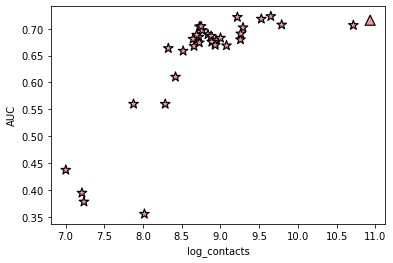

In [62]:
    sc_bar = sns.scatterplot(data=dk[dk['resolution']==10], x='log_contacts', y='AUC', style='agg_type', color=color_1,edgecolor="black", s=100, linewidth=1.2, markers =  {"proj_agg": "*", "pearson": "o", "spearman": "^"})
    sc_bar.legend().remove()
    
    

In [ ]:
 sns.scatterplot(data=dk[dk['resolution']==10], x='log_contacts', y='AUC', style='agg_type', color=color_1,edgecolor="black", s=100, linewidth=1.2, markers =  {"proj_agg": "*", "pearson": "o", "spearman": "^"})
    
    

<AxesSubplot:xlabel='log_contacts', ylabel='AUC'>

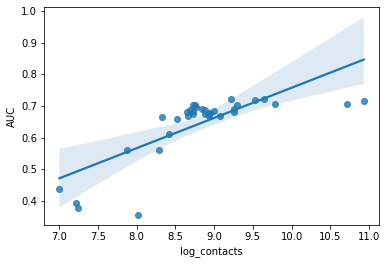

In [59]:
 sns.regplot(data=dk[dk['resolution']==10], x='log_contacts', y='AUC')

[]

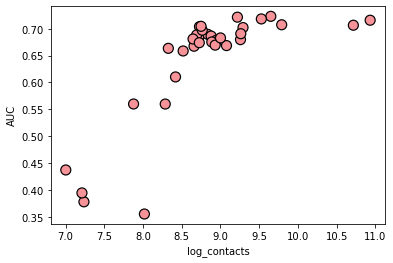

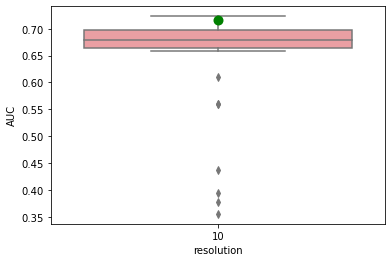

In [54]:
    
    import matplotlib.pyplot as plt
    sc_bar = sns.scatterplot(data=dk[dk['resolution']==10], x='log_contacts', y='AUC', style='agg_type', color=color_1,edgecolor="black", s=100, linewidth=1.2, markers =  {"proj_agg": "o", "pearson": "o", "spearman": "o"})
    sc_bar.legend().remove()
    #sc_bar = sns.scatterplot(data=dk[dk['resolution']==100], x='log_contacts', y='auc')
    #dk['log_contacts'] = dk['log_contacts'].round(0)
    #sc_bar = sns.lineplot(data=dk[dk['resolution']==10], x='log_contacts', y='auc')
    
    #sc_bar = sns.regplot(data=dk[dk['resolution']==10], x='log_contacts', y='auc')
    #sc_bar.set(ylim=(0.55, 0.73))
    plt.plot()
    #plt.savefig(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/{species_list}_ind_vs_agg_inter.pdf',
    #        transparent=True)
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    #sns.scatterplot(x='resolution', y='auc', data=dt[dt['agg_type']=='all'], ax=ax)
    axb = sns.boxplot(x='resolution', y='AUC', data=dk[dk['agg_type']=='proj_agg'], ax=ax, color=color_1, orient="v")
    #for i, patch in enumerate(axb.artists):
        # Boxes from left to right

     #   patch.set_hatch('//')
    #sns.swarmplot(x='resolution', y='auc', data=dk[dk['agg_type']=='pearson'], ax=ax, size=10, color=color_2, orient="v")
    sns.swarmplot(x='resolution', y='AUC', data=dk[dk['agg_type']=='spearman'], ax=ax, size=10, color="green", orient="v")
    #sns.lineplot(y='resolution', x='auc', data=dt[dt['agg_type']=='all'], ax=ax, color="green")
    #ax.set(ylim=(0.5, 0.67))
    plt.plot()
    
    #plt.savefig(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/{species_list}_ind_vs_agg_all_resol_inter.pdf',
    #        transparent=True)

In [17]:
                                        df2 = run_egad(marker_table, df_spr_corr)
                                        df2['species'] = species
                                        df2['resolution'] = resolution
                                        df2['proj'] = proj
                                        df2['agg_type'] = 'proj_agg'
                                        #print (proj)
                                        
                                        df_seq_depth_subset = df_seq_depth[df_seq_depth['proj_id'].isin([proj])]
                                        df2['counts_inter'] = df_seq_depth_subset['counts_inter'].sum()

(6387, 6387)
(6387, 80)
0.9595095506497573
0.0


TypeError: 'tuple' object does not support item assignment

In [74]:
    df_ind=pd.concat(empty_list)

    df = pd.concat([df_whole_agg, df_ind])

    dt = df.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()


ValueError: No objects to concatenate

In [ ]:
    df_ind=pd.concat(empty_list)

    df = pd.concat([df_whole_agg, df_ind])

    dt = df.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()

    for species in species_list: 
        df_seq_depth = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_project_network_details.tsv', sep='\t')
        df_seq_depth['species'] = species
        df_seq_depth['project'] = [x.strip() for x in df_seq_depth['project']]
        df_seq_depth['experiment type'] = [x.strip() for x in df_seq_depth['experiment type']]
        #dk['experiment type'] = [x if x=='Hi-C' else 'o' for x in dk['experiment type']]

    import numpy as np
    dt['log_contacts'] = [np.log10(x) for x in dt['counts_inter']]

    dt = dt.merge(df_seq_depth, left_on='proj', right_on='project')
    dk = pd.concat([dt, df_whole_agg.groupby(['proj', 'resolution', 'agg_type'])['AUC', 'counts_inter'].mean().reset_index()])
    dk['log_contacts'] = [np.log10(x) for x in dk['counts_inter']]

    dk['experiment type'] = [x if x=='Hi-C' else 'o' for x in dk['experiment type']]
    
    #dk = dk[dk['auc'] > 0.5]
    #dk = dk[dk['agg_type']=='proj_agg']
    #print (dk)
    
    
    
    
    import matplotlib.pyplot as plt
    sc_bar = sns.scatterplot(data=dk[dk['resolution']==25], x='log_contacts', y='AUC', style='agg_type', color=color_1,edgecolor="black", s=100, linewidth=1.2, markers =  {"proj_agg": "*", "pearson": "o", "spearman": "^"})
    sc_bar.legend().remove()
    #sc_bar = sns.scatterplot(data=dk[dk['resolution']==100], x='log_contacts', y='auc')
    #dk['log_contacts'] = dk['log_contacts'].round(0)
    #sc_bar = sns.lineplot(data=dk[dk['resolution']==10], x='log_contacts', y='auc')
    
    #sc_bar = sns.regplot(data=dk[dk['resolution']==10], x='log_contacts', y='auc')
    #sc_bar.set(ylim=(0.5, 0.67))
    plt.plot()
    #plt.savefig(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/{species_list}_ind_vs_agg_inter.pdf',
    #        transparent=True)
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    #sns.scatterplot(x='resolution', y='auc', data=dt[dt['agg_type']=='all'], ax=ax)
    axb = sns.boxplot(x='resolution', y='AUC', data=dk[dk['agg_type']=='proj_agg'], ax=ax, color=color_1, orient="v")
    #for i, patch in enumerate(axb.artists):
        # Boxes from left to right

     #   patch.set_hatch('//')
    #sns.swarmplot(x='resolution', y='auc', data=dk[dk['agg_type']=='pearson'], ax=ax, size=10, color=color_2, orient="v")
    sns.swarmplot(x='resolution', y='AUC', data=dk[dk['agg_type']=='spearman'], ax=ax, size=10, color="green", orient="v")
    #sns.lineplot(y='resolution', x='auc', data=dt[dt['agg_type']=='all'], ax=ax, color="green")
    #ax.set(ylim=(0.5, 0.67))
    plt.plot()
    
    #plt.savefig(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/figures/{species_list}_ind_vs_agg_all_resol_inter.pdf',
    #        transparent=True)


In [70]:
dt

NameError: name 'dt' is not defined

In [62]:
SRP_name='aggregates'
SRP_name='SRP217487'
resolution='10kbp_raw'
#df_jac_corr_list = []
#for resolution in ['100kbp_raw', '250kbp_raw', '10', 40 , 25, snhic]:
for resolution in ['25kbp_raw']:
    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

    jac_sim = hm.hiCMatrix(exp_file_path)




    all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
    #df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)
    df_jac_corr_list.append(pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes))
    
    df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr_list[7])


In [28]:
SRP_name='aggregates'
resolution='40kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5'

jac_exp = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_exp.cut_intervals]
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [14]:
df_jac_corr.sum().sum()

57238269.755088426

In [220]:
import pandas as pd
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)
gitdf = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/ScTypeDB_full_github.tsv', sep='\t')



df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)



gitdf.rename(columns = {'tissueType':'Tissue', 'cellName':'Cell type',
                              'geneSymbolmore1':'Marker genes'}, inplace = True)

df = pd.concat([gitdf, df])
df = df[df['Tissue'].isin(['Brain', 'Adrenal'])]
df['combined_type'] = df['Tissue'] + '-' + df['Cell type']
df = df.drop_duplicates(subset='combined_type')
#df['combined_type'] = df['Tissue'] 
#df['combined_type'] =  df['Cell type']
tissue_type_list = df['combined_type'].drop_duplicates().tolist()

all_gene_list = df['Marker genes'].str.cat(sep=',').split(",")

data_tissue = df.groupby(['combined_type']).apply(lambda grp: grp['Marker genes'].str.cat(sep=',').split(","))

all_gene_list = list(set(all_gene_list))

nested_gene_marker_tissue_list = []
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/gene_name_ensg.txt', sep='\t')
df.dropna(inplace=True)
dict_gene_name_to_ensg = df.set_index('Gene name').to_dict()['Gene stable ID']

for i in tissue_type_list:
    
    gene_for_given_tissue = data_tissue[data_tissue.index ==i][0]
    #chrom_for_given_tisse = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list]
    
    particular_gene_tissue = [ 1 if x in gene_for_given_tissue else 0 for x in all_gene_list]
    nested_gene_marker_tissue_list.append(particular_gene_tissue)

    

all_gene_list = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list ]
marker_gene_table = pd.DataFrame(nested_gene_marker_tissue_list, columns = all_gene_list, index=tissue_type_list)


<ipython-input-220-58d480932ef6>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)
<ipython-input-220-58d480932ef6>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)


In [189]:
marker_gene_table

ENSG00000115386  ENSG00000139287  del  \
Immune system-Pro-B cells                   0                0    0   
Immune system-Pre-B cells                   0                0    0   
Immune system-Naive B cells                 0                0    0   
Immune system-Memory B cells                0                0    0   
Immune system-Plasma B cells                0                0    0   
...                                       ...              ...  ...   
Teeth-Odontoblasts                          0                0    0   
Teeth-Endothelial cells                     0                0    0   
Teeth-Immune cells                          0                0    0   
Teeth-Glial cells                           0                0    0   
Teeth-Epithelial cells                      0                0    0   

                              ENSG00000107447  ENSG00000122852  del  \
Immune system-Pro-B cells                   1                0    0   
Immune system-Pre-B cells                   0                0    0   
Immune system-Naive B cells                 0                0    0   
Immune system-Memory B cells                0                0    0   
Immune system-Plasma B cells                0                0    0   
...                                       ...              ...  ...   
Teeth-Odontoblasts                          0                0    0   
Teeth-Endothelial cells                     0                0    0   
Teeth-Immune cells                          0                0    0   
Teeth-Glial cells                           0                0    0   
Teeth-Epithelial cells                      0                0    0   

                              ENSG00000054983  del  ENSG00000012048  \
Immune system-Pro-B cells                   0    0                0   
Immune system-Pre-B cells                   0    0                0   
Immune system-Naive B cells                 0    0                0   
Immune system-Memory B cells                0    0                0   
Immune system-Plasma B cells                0    0                0   
...                                       ...  ...              ...   
Teeth-Odontoblasts                          0    0                0   
Teeth-Endothelial cells                     0    0                0   
Teeth-Immune cells                          0    0                0   
Teeth-Glial cells                           0    0                0   
Teeth-Epithelial cells                      0    0                0   

                              ENSG00000078401  ...  ENSG00000183662  \
Immune system-Pro-B cells                   0  ...                0   
Immune system-Pre-B cells                   0  ...                0   
Immune system-Naive B cells                 0  ...                0   
Immune system-Memory B cells                0  ...                0   
Immune system-Plasma B cells                0  ...                0   
...                                       ...  ...              ...   
Teeth-Odontoblasts                          0  ...                0   
Teeth-Endothelial cells                     1  ...                0   
Teeth-Immune cells                          0  ...                0   
Teeth-Glial cells                           0  ...                0   
Teeth-Epithelial cells                      0  ...                0   

                              ENSG00000172936  ENSG00000166573  \
Immune system-Pro-B cells                   0                0   
Immune system-Pre-B cells                   0                0   
Immune system-Naive B cells                 0                0   
Immune system-Memory B cells                0                0   
Immune system-Plasma B cells                0                0   
...                                       ...              ...   
Teeth-Odontoblasts                          0                0   
Teeth-Endothelial cells                     0                0   
Teeth-Immune cells      

In [83]:
set(gitdf) - set (df)

{'Adrenal', 'Intestine', 'Placenta', 'Spleen', 'Stomach', 'Thymus'}

In [84]:
set(df) - set (gitdf)

{'Embryo',
 'Gastrointestinal tract',
 'Ovary',
 'Skin',
 'Teeth',
 'Testis',
 'White adipose tissue'}

In [183]:
marker_gene_table

ENSG00000115386  ENSG00000139287  del  \
Immune system-Pro-B cells                   0                0    0   
Immune system-Pre-B cells                   0                0    0   
Immune system-Naive B cells                 0                0    0   
Immune system-Memory B cells                0                0    0   
Immune system-Plasma B cells                0                0    0   
...                                       ...              ...  ...   
Teeth-Odontoblasts                          0                0    0   
Teeth-Endothelial cells                     0                0    0   
Teeth-Immune cells                          0                0    0   
Teeth-Glial cells                           0                0    0   
Teeth-Epithelial cells                      0                0    0   

                              ENSG00000107447  ENSG00000122852  del  \
Immune system-Pro-B cells                   1                0    0   
Immune system-Pre-B cells                   0                0    0   
Immune system-Naive B cells                 0                0    0   
Immune system-Memory B cells                0                0    0   
Immune system-Plasma B cells                0                0    0   
...                                       ...              ...  ...   
Teeth-Odontoblasts                          0                0    0   
Teeth-Endothelial cells                     0                0    0   
Teeth-Immune cells                          0                0    0   
Teeth-Glial cells                           0                0    0   
Teeth-Epithelial cells                      0                0    0   

                              ENSG00000054983  del  ENSG00000012048  \
Immune system-Pro-B cells                   0    0                0   
Immune system-Pre-B cells                   0    0                0   
Immune system-Naive B cells                 0    0                0   
Immune system-Memory B cells                0    0                0   
Immune system-Plasma B cells                0    0                0   
...                                       ...  ...              ...   
Teeth-Odontoblasts                          0    0                0   
Teeth-Endothelial cells                     0    0                0   
Teeth-Immune cells                          0    0                0   
Teeth-Glial cells                           0    0                0   
Teeth-Epithelial cells                      0    0                0   

                              ENSG00000078401  ...  ENSG00000183662  \
Immune system-Pro-B cells                   0  ...                0   
Immune system-Pre-B cells                   0  ...                0   
Immune system-Naive B cells                 0  ...                0   
Immune system-Memory B cells                0  ...                0   
Immune system-Plasma B cells                0  ...                0   
...                                       ...  ...              ...   
Teeth-Odontoblasts                          0  ...                0   
Teeth-Endothelial cells                     1  ...                0   
Teeth-Immune cells                          0  ...                0   
Teeth-Glial cells                           0  ...                0   
Teeth-Epithelial cells                      0  ...                0   

                              ENSG00000172936  ENSG00000166573  \
Immune system-Pro-B cells                   0                0   
Immune system-Pre-B cells                   0                0   
Immune system-Naive B cells                 0                0   
Immune system-Memory B cells                0                0   
Immune system-Plasma B cells                0                0   
...                                       ...              ...   
Teeth-Odontoblasts                          0                0   
Teeth-Endothelial cells                     0                0   
Teeth-Immune cells      

In [158]:
df_TF = gitdf[gitdf['species'] != 'Mm']
df_TF['ensg_gene'] = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in df_TF['official gene symbol'] ]



df_TF = df_TF[df_TF['ensg_gene'] != 'del']



df_TF['counter'] = 1

df_TF_egad = df_TF.pivot_table(index=["ensg_gene"], columns='germ layer', values='counter',  aggfunc='max').T
marker_gene_table = df_TF_egad.fillna(0)


<ipython-input-158-47fc4ea4522e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TF['ensg_gene'] = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in df_TF['official gene symbol'] ]


In [208]:
import pandas as pd
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/PanglaoDB_markers_27_Mar_2020.tsv', sep='\t')
df[df['species'] != 'Mm']

df = df[df['tissueType'].isin(['Brain'])]
df['combined_type'] = df['organ'] + '-' + df['cell type']

#df['combined_type'] = df['Tissue'] 
#df['combined_type'] =  df['Cell type']
tissue_type_list = df['combined_type'].drop_duplicates().tolist()

all_gene_list = df['official gene symbol'].str.cat(sep=',').split(",")

data_tissue = df.groupby(['combined_type']).apply(lambda grp: grp['official gene symbol'].str.cat(sep=',').split(","))

all_gene_list = list(set(all_gene_list))

nested_gene_marker_tissue_list = []

for i in tissue_type_list:
    gene_for_given_tissue = data_tissue[data_tissue.index ==i][0]
    particular_gene_tissue = [ 1 if x in gene_for_given_tissue else 0 for x in all_gene_list]
    nested_gene_marker_tissue_list.append(particular_gene_tissue)

    
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/gene_name_ensg.txt', sep='\t')
df.dropna(inplace=True)
dict_gene_name_to_ensg = df.set_index('Gene name').to_dict()['Gene stable ID']
all_gene_list = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list ]
marker_gene_table = pd.DataFrame(nested_gene_marker_tissue_list, columns = all_gene_list, index=tissue_type_list)


KeyError: 'tissueType'

In [102]:
df = marker_gene_table.sum().reset_index()

In [103]:
marker_gene_table = marker_gene_table.drop(df[df[0]>1]['index'].tolist(), axis = 1)

<AxesSubplot:ylabel='Count'>

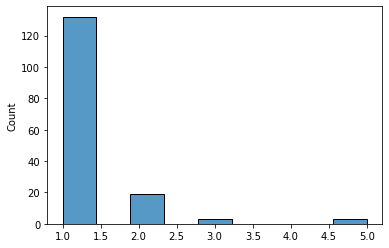

In [51]:
sns.histplot(marker_gene_table.sum())

(261, 261)
(261, 36)
0.9680715197956578
0.0


<ipython-input-12-246835a56923>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


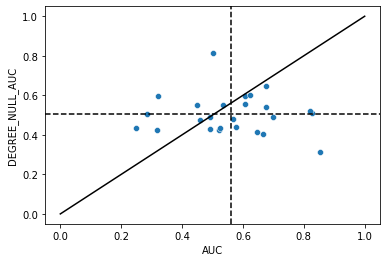

In [221]:
df_2d_jac, go_chrom  = run_egad(marker_gene_table.T, df_jac_gw)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [222]:
df_2d_jac['AUC'].mean()

0.5595002913340569

In [223]:
df_2d_jac.sort_values(by=['AUC']).tail(30)

AUC  AVG_NODE_DEGREE  \
Adrenal-Sympathoblasts                 0.249016       270.226390   
Brain-Oligodendrocytes                 0.284360       272.859779   
Brain-Neural Progenitor cells          0.318399       265.750945   
Brain-Schwann precursor cells          0.320261       290.486189   
Adrenal-SLC26A4_PAEP positive cells    0.447707       283.895108   
Brain-Mature neurons                   0.458630       276.327911   
Brain-GABAergic neurons                0.490196       257.173171   
Brain-Microglial cells                 0.491468       269.383493   
Brain-Immune system cells              0.500000       308.930444   
Adrenal-Schwann cells                  0.521400       264.949191   
Adrenal-Lymphoid cells                 0.524682       260.901189   
Brain-Cancer stem cells                0.535784       282.416899   
Brain-Glutamatergic neurons            0.566710       269.699737   
Adrenal-Megakaryocytes                 0.577867       259.799391   
Brain-Astrocytes                       0.606127       283.187385   
Adrenal-Erythroblasts                  0.607067       282.010021   
Adrenal-Vascular endothelial cells     0.622621       288.407145   
Brain-Radial glial cells               0.646756       259.686479   
Adrenal-Stromal cells                  0.665788       265.989080   
Adrenal-Myeloid cells                  0.675911       270.970484   
Brain-Endothelial cells                0.676420       295.325936   
Brain-Dopaminergic neurons             0.697619       272.029501   
Adrenal-CSH1_CSH2 positive cells       0.820580       287.118315   
Brain-Neuroepithelial cells            0.828327       279.264191   
Brain-Oligodendrocyte precursor cells  0.853813       237.095503   

                                       DEGREE_NULL_AUC   P_Value  
Adrenal-Sympathoblasts                        0.433071  0.018456  
Brain-Oligodendrocytes                        0.506693  0.008096  
Brain-Neural Progenitor cells                 0.425680  0.008982  
Brain-Schwann precursor cells                 0.598693  0.101839  
Adrenal-SLC26A4_PAEP positive cells           0.552028  0.129433  
Brain-Mature neurons                          0.477273  0.371641  
Brain-GABAergic neurons                       0.430719  0.178585  
Brain-Microglial cells                        0.489198  0.330668  
Brain-Immune system cells                     0.813072  0.415369  
Adrenal-Schwann cells                         0.424812  0.396232  
Adrenal-Lymphoid cells                        0.435794  0.267279  
Brain-Cancer stem cells                       0.552941  0.409272  
Brain-Glutamatergic neurons                   0.479753  0.171519  
Adrenal-Megakaryocytes                        0.441455  0.042519  
Brain-Astrocytes                              0.554201  0.071724  
Adrenal-Erythroblasts                         0.598182  0.002765  
Adrenal-Vascular endothelial cells            0.602789  0.090246  
Brain-Radial glial cells                      0.413818  0.045605  
Adrenal-Stromal cells                         0.406621  0.047102  
Adrenal-Myeloid cells                         0.542545  0.034683  
Brain-Endothelial cells                       0.648929  0.018947  
Brain-Dopaminergic neurons                    0.490741  0.055307  
Adrenal-CSH1_CSH2 positive cells              0.519375  0.000020  
Brain-Neuroepithelial cells                   0.512846  0.004822  
Brain-Oligodendrocyte precursor cells         0.315686  0.002726

(2430, 2430)
(2430, 324)
0.9943377533912513
0.0


<ipython-input-12-246835a56923>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


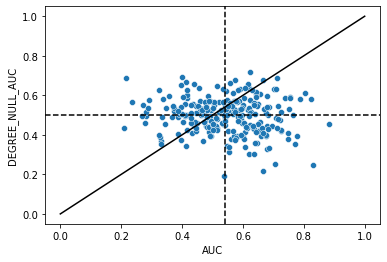

In [190]:
df_2d_jac, go_chrom  = run_egad(marker_gene_table.T, df_jac_corr_intra)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [192]:
df_2d_jac.sort_values(by=['AUC']).tail(10)

AUC  AVG_NODE_DEGREE  \
Immune system-Neutrophils                      0.753567      1233.089870   
Placenta-IGFBP1_DKK1 positive cells            0.753950      1234.348106   
Gastrointestinal tract-Enterochromaffin cells  0.764910      1222.946982   
Immune system-Macrophages                      0.770894      1200.991514   
Intestine-Lymphoid cells                       0.778593      1208.634666   
Intestine-Erythroblasts                        0.786054      1221.515029   
Stomach-Myeloid cells                          0.804727      1234.866358   
Adrenal-Myeloid cells                          0.823953      1217.882820   
White adipose tissue-Mesothelial cells         0.830409      1190.292587   
Adrenal-CSH1_CSH2 positive cells               0.883454      1213.186840   

                                               DEGREE_NULL_AUC   P_Value  
Immune system-Neutrophils                             0.589350  0.000156  
Placenta-IGFBP1_DKK1 positive cells                   0.585967  0.002217  
Gastrointestinal tract-Enterochromaffin cells         0.500083  0.001795  
Immune system-Macrophages                             0.353940  0.012746  
Intestine-Lymphoid cells                              0.394096  0.004614  
Intestine-Erythroblasts                               0.583254  0.000067  
Stomach-Myeloid cells                                 0.610987  0.000033  
Adrenal-Myeloid cells                                 0.583111  0.001632  
White adipose tissue-Mesothelial cells                0.246800  0.000921  
Adrenal-CSH1_CSH2 positive cells                      0.455121  0.000007

(2430, 2430)
(2430, 324)
0.9943377533912513
0.0


<ipython-input-12-246835a56923>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


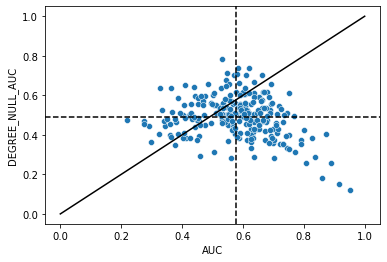

In [179]:
df_2d_jac, go_chrom  = run_egad(marker_gene_table.T, df_jac_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [184]:
df_2d_jac.sort_values(by=['AUC']).tail(10)

AUC  AVG_NODE_DEGREE  \
White adipose tissue-Adipocytes                   0.791810     6.942758e+07   
Brain-Neuroepithelial cells                       0.799741     7.563654e+07   
White adipose tissue-Smooth Muscle cells          0.807774     6.047817e+07   
Adrenal-Stromal cells                             0.825580     7.282575e+07   
White adipose tissue-Lymphatic Endothelial cells  0.836379     6.743732e+07   
White adipose tissue-Mesothelial cells            0.860274     6.058658e+07   
Immune system-Eosinophils                         0.874426     7.586037e+07   
White adipose tissue-Endothelial cells            0.890739     6.223762e+07   
White adipose tissue-Pericytes                    0.916563     5.733133e+07   
White adipose tissue-Endometrium                  0.951831     5.453354e+07   

                                                  DEGREE_NULL_AUC  \
White adipose tissue-Adipocytes                          0.353414   
Brain-Neuroepithelial cells                              0.423101   
White adipose tissue-Smooth Muscle cells                 0.256930   
Adrenal-Stromal cells                                    0.381606   
White adipose tissue-Lymphatic Endothelial cells         0.286530   
White adipose tissue-Mesothelial cells                   0.183165   
Immune system-Eosinophils                                0.406281   
White adipose tissue-Endothelial cells                   0.258882   
White adipose tissue-Pericytes                           0.152433   
White adipose tissue-Endometrium                         0.123380   

                                                       P_Value  
White adipose tissue-Adipocytes                   1.003347e-03  
Brain-Neuroepithelial cells                       5.484859e-03  
White adipose tissue-Smooth Muscle cells          5.326387e-04  
Adrenal-Stromal cells                             2.510403e-03  
White adipose tissue-Lymphatic Endothelial cells  2.986060e-07  
White adipose tissue-Mesothelial cells            2.220305e-04  
Immune system-Eosinophils                         1.556932e-04  
White adipose tissue-Endothelial cells            6.014601e-07  
White adipose tissue-Pericytes                    4.161103e-07  
White adipose tissue-Endometrium                  5.749189e-08

(2118, 2118)
(2118, 324)
0.9941666958113291
0.0


<ipython-input-12-246835a56923>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


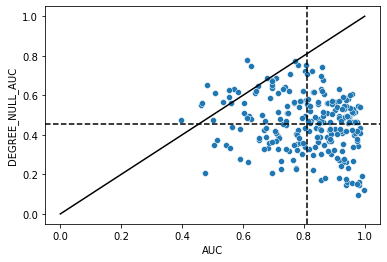

In [174]:
df_2d_exp, go_chrom  = run_egad(marker_gene_table.T, df_exp_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_exp, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_exp['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_exp['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [175]:
df_2d_jac.reset_index(inplace=True)
df_2d_exp.reset_index(inplace=True)
coexp_contact = df_2d_jac.merge(df_2d_exp, left_on='index', right_on='index')

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AUC_y', ylabel='AUC_x'>

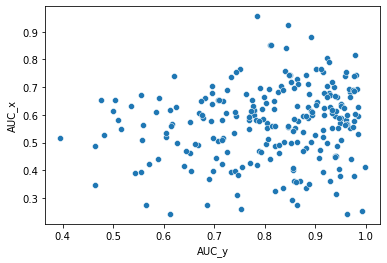

In [176]:
sns.scatterplot(coexp_contact['AUC_y'], coexp_contact['AUC_x'])

In [168]:
df_2d_exp.sort_values(by=['AUC']).tail(20)

AUC  AVG_NODE_DEGREE  \
Immune system-Basophils                    0.966514       686.331847   
Immune system-Naive CD8+ T cells           0.968314       821.950864   
Immune system-γδ-T cells                   0.968605       769.553020   
Immune system--T cells                     0.968899       769.553020   
Placenta-Lymphoid cells                    0.969792       713.832540   
Placenta-Myeloid cells                     0.973610       674.424280   
Stomach-Lymphoid cells                     0.974136       777.257123   
Placenta-Megakaryocytes                    0.975818       715.116747   
Stomach-Squamous epithelial cells          0.975893       421.026389   
Heart-Lymphoid cells                       0.976310       680.726533   
Immune system-Mast cells                   0.976431       838.248697   
Intestine-Chromaffin cells                 0.978456       351.112587   
Immune system-Eosinophils                  0.978604       644.942277   
Adrenal-Erythroblasts                      0.980016       422.470634   
Placenta-AFP_ALB positive cells            0.982184       433.979287   
Adrenal-Lymphoid cells                     0.983204       745.482143   
Immune system-ISG expressing immune cells  0.984182       845.937118   
Intestine-Lymphoid cells                   0.984755       729.664059   
Muscle-Erythroblasts                       0.992657       456.658236   
Intestine-Erythroblasts                    0.997374       395.921133   

                                           DEGREE_NULL_AUC       P_Value  
Immune system-Basophils                           0.396859  8.957349e-08  
Immune system-Naive CD8+ T cells                  0.515133  4.288808e-10  
Immune system-γδ-T cells                          0.464349  8.119871e-11  
Immune system--T cells                            0.464349  5.924728e-11  
Placenta-Lymphoid cells                           0.411246  2.444644e-08  
Placenta-Myeloid cells                            0.380619  8.182613e-09  
Stomach-Lymphoid cells                            0.467312  2.445967e-09  
Placenta-Megakaryocytes                           0.416996  4.939503e-07  
Stomach-Squamous epithelial cells                 0.149151  1.253213e-05  
Heart-Lymphoid cells                              0.368074  4.947886e-10  
Immune system-Mast cells                          0.545533  3.501668e-05  
Intestine-Chromaffin cells                        0.098011  3.959878e-05  
Immune system-Eosinophils                         0.343304  5.867062e-04  
Adrenal-Erythroblasts                             0.146979  2.215531e-06  
Placenta-AFP_ALB positive cells                   0.163472  1.149528e-07  
Adrenal-Lymphoid cells                            0.433682  4.165141e-09  
Immune system-ISG expressing immune cells         0.540646  3.247684e-07  
Intestine-Lymphoid cells                          0.410782  1.164714e-06  
Muscle-Erythroblasts                              0.193468  8.335917e-09  
Intestine-Erythroblasts                           0.122622  7.362984e-09

In [169]:
df_2d_jac.sort_values(by=['AUC']).tail(20)

AUC  AVG_NODE_DEGREE  \
Adrenal-Erythroblasts                             0.744015     7.830639e+07   
Eye-GABAergic amacrine cells                      0.745241     7.268417e+07   
Stomach-PDE1C_ACSM3 positive cells                0.754132     7.301663e+07   
Heart-Megakaryocytes                              0.754374     7.470928e+07   
Immune system-Intermediate monocytes              0.755359     8.918103e+07   
Adrenal-SLC26A4_PAEP positive cells               0.757836     8.059366e+07   
Eye-Glycinergic amacrine cells                    0.758436     7.143455e+07   
Immune system-Non-classical monocytes             0.765285     7.983960e+07   
Adrenal-Stromal cells                             0.766023     7.476892e+07   
Spleen-Stromal cells                              0.767047     6.456358e+07   
White adipose tissue-Adipocytes                   0.789524     7.134295e+07   
Adrenal-CSH1_CSH2 positive cells                  0.800541     8.125798e+07   
Brain-Neuroepithelial cells                       0.805471     7.778916e+07   
Immune system-Eosinophils                         0.817843     7.799499e+07   
White adipose tissue-Mesothelial cells            0.842210     6.219281e+07   
White adipose tissue-Lymphatic Endothelial cells  0.851003     6.926410e+07   
White adipose tissue-Endothelial cells            0.853651     6.394237e+07   
White adipose tissue-Adipose progenitor cells     0.879674     6.533446e+07   
White adipose tissue-Pericytes                    0.924143     5.884099e+07   
White adipose tissue-Endometrium                  0.955802     5.597243e+07   

                                                  DEGREE_NULL_AUC  \
Adrenal-Erythroblasts                                    0.472669   
Eye-GABAergic amacrine cells                             0.350712   
Stomach-PDE1C_ACSM3 positive cells                       0.374127   
Heart-Megakaryocytes                                     0.413942   
Immune system-Intermediate monocytes                     0.611174   
Adrenal-SLC26A4_PAEP positive cells                      0.496535   
Eye-Glycinergic amacrine cells                           0.331923   
Immune system-Non-classical monocytes                    0.509710   
Adrenal-Stromal cells                                    0.379877   
Spleen-Stromal cells                                     0.327521   
White adipose tissue-Adipocytes                          0.352323   
Adrenal-CSH1_CSH2 positive cells                         0.406855   
Brain-Neuroepithelial cells                              0.421812   
Immune system-Eosinophils                                0.404308   
White adipose tissue-Mesothelial cells                   0.181567   
White adipose tissue-Lymphatic Endothelial cells         0.284352   
White adipose tissue-Endothelial cells                   0.258357   
White adipose tissue-Adipose progenitor cells            0.314332   
White adipose tissue-Pericytes                           0.151323   
White adipose tissue-Endometrium                         0.122448   

                                                       P_Value  
Adrenal-Erythroblasts                             1.577830e-02  
Eye-GABAergic amacrine cells                      1.214904e-02  
Stomach-PDE1C_ACSM3 positive cells                1.073852e-03  
Heart-Megakaryocytes                              1.688054e-03  
Immune system-Intermediate monocytes              2.788973e-03  
Adrenal-SLC26A4_PAEP positive cells               1.268912e-02  
Eye-Glycinergic amacrine cells                    6.499352e-03  
Immune system-Non-classical monocytes             2.098806e-04  
Adrenal-Stromal cells                             5.048967e-03  
Spleen-Stromal cells                              3.439434e-03  
White adipose tissue-Adipocytes                   1.522735e-03  
Adrenal-CSH1_CSH2 positive cells                  8.298341e-05  
Brain-Neuroepithelial cells                       2.012711e-03  
Immune system-Eosinophils          

In [215]:
y = marker_gene_table.T

genes_intersect = y.index.intersection(df_jac_corr.index)

nw = df_jac_corr.loc[genes_intersect, genes_intersect]

marker_gene_table = marker_gene_table.loc[:, genes_intersect]

In [216]:
species= marker_gene_table.T.idxmax(axis=1)

In [218]:
species.unique()

array(['Brain-Immune system cells', 'Brain-Microglial cells',
       'Brain-Astrocytes', 'Brain-Oligodendrocytes',
       'Brain-Dopaminergic neurons', 'Brain-GABAergic neurons',
       'Brain-Neuroblasts', 'Brain-Endothelial cells',
       'Brain-Cholinergic neurons', 'Brain-Radial glial cells',
       'Brain-Mature neurons', 'Brain-Neural Progenitor cells',
       'Brain-Immature neurons', 'Brain-Neuroepithelial cells',
       'Brain-Glutamatergic neurons', 'Brain-Tanycytes',
       'Brain-Non myelinating Schwann cells',
       'Brain-Oligodendrocyte precursor cells',
       'Brain-Myelinating Schwann cells', 'Brain-Cancer cells',
       'Brain-Cancer stem cells', 'Brain-Neural stem cells',
       'Brain-Serotonergic neurons', 'Brain-Schwann precursor cells'],
      dtype=object)

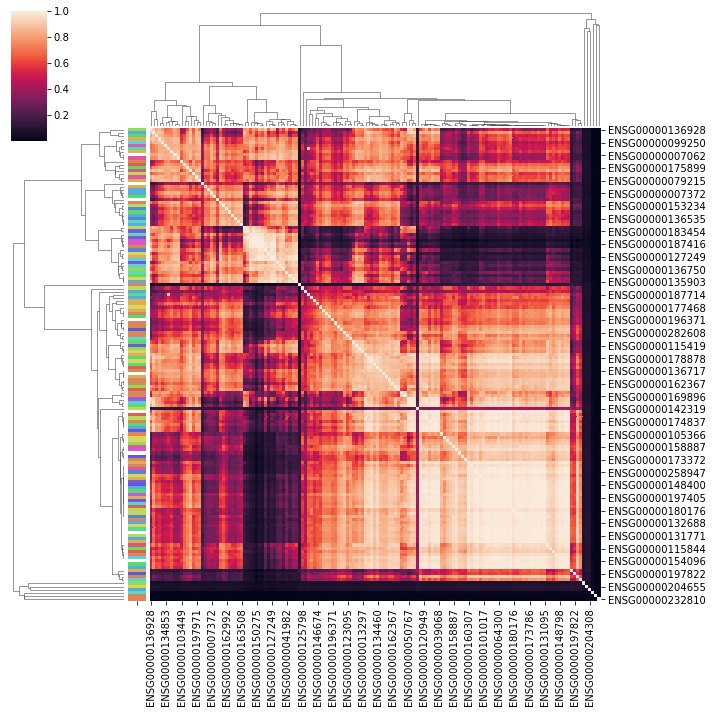

In [219]:
lut = dict(zip(species.unique(), sns.color_palette("hls", 20)))
#lut = dict(zip(species.unique(), "grrbrrryry"))
#lut = dict(zip(species.unique(), "rrbb"))
#lut = dict(zip(['Brain-Astrocytes', 'Brain-Endothelial cells', 'Brain-Microglial cells','Brain-GABAergic neurons'], sns.color_palette("hls", 4)))
row_colors = species.map(lut)
g = sns.clustermap(nw, row_colors=row_colors, row_cluster=True, metric="correlation")
